In [37]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from PIL import Image
from datasets import load_dataset

import matplotlib.pyplot as plt

np.set_printoptions(precision=2)

# **Load Dataset**

In [38]:
ds = load_dataset("keremberke/chest-xray-classification", name="full")
ds

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4077
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 582
    })
})

# **Exploratory Data Analysis**

Dataset Information:
Number of samples in the training set: 4077 (70.00%)
Number of samples in the validation set: 1165 (20.00%)
Number of samples in the test set: 582 (9.99%)



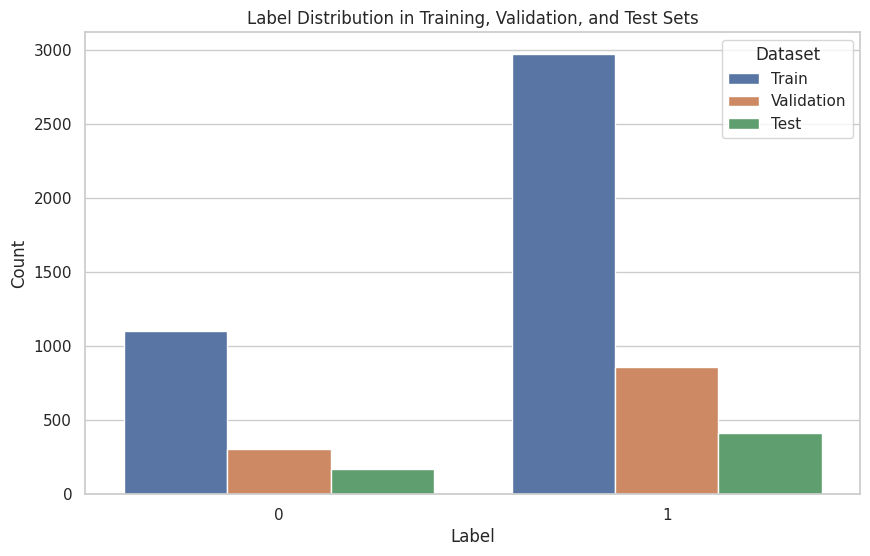

In [48]:
# Access the train, validation, and test sets
train_data = ds['train']
validation_data = ds['validation']
test_data = ds['test']

# Calculate the number of samples in each set
num_train_samples = len(train_data)
num_validation_samples = len(validation_data)
num_test_samples = len(test_data)
total_samples = num_train_samples + num_validation_samples + num_test_samples

# Calculate the percentage of samples in each set
train_percentage = (num_train_samples / total_samples) * 100
validation_percentage = (num_validation_samples / total_samples) * 100
test_percentage = (num_test_samples / total_samples) * 100

# Display basic information about the dataset
print("Dataset Information:")
print(f"Number of samples in the training set: {num_train_samples} ({train_percentage:.2f}%)")
print(f"Number of samples in the validation set: {num_validation_samples} ({validation_percentage:.2f}%)")
print(f"Number of samples in the test set: {num_test_samples} ({test_percentage:.2f}%)")
print()


# Convert the dataset to Pandas DataFrames for easier analysis
train_df = pd.DataFrame(train_data)
validation_df = pd.DataFrame(validation_data)
test_df = pd.DataFrame(test_data)

# Combine the DataFrames into one for easier plotting
combined_df = pd.concat([train_df.assign(dataset='Train'), validation_df.assign(dataset='Validation'), test_df.assign(dataset='Test')])

# Set the style of the plot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# Plot the combined dataset with different colors for each dataset
sns.countplot(data=combined_df, x='labels', hue='dataset')

plt.title("Label Distribution in Training, Validation, and Test Sets")
plt.xlabel("Label")
plt.ylabel("Count")
plt.legend(title='Dataset')

plt.show()

# **Preprocess Data**

In [40]:
# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        image = self.data[idx]['image']  # Access the image directly if available
        if self.transform:
            image = self.transform(image)
        label = self.data[idx]['labels']
        return image, label


In [41]:
# Modify the transform to convert grayscale to RGB
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to RGB by repeating the single channel
    transforms.Resize((224, 224)),  # ResNet requires 224x224 input images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize as per ImageNet standards
])


# Assuming you have a CustomDataset class defined (similar to earlier)
# Apply transformations to your dataset
train_dataset = CustomDataset(ds['train'], transform=transform)
val_dataset = CustomDataset(ds['validation'], transform=transform)
test_dataset = CustomDataset(ds['test'], transform=transform)

# DataLoader objects for batch processing
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# **Visualize the data**

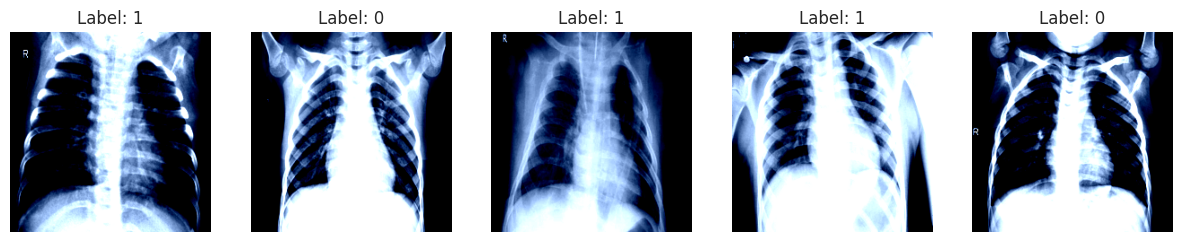

In [45]:
import random
import matplotlib.pyplot as plt

# Define a function to visualize a random subset of the data
def visualize_random_data(data_loader, num_samples):
    # Convert DataLoader to a list of images and labels
    images, labels = [], []
    for image_batch, label_batch in data_loader:
        images.extend(image_batch)
        labels.extend(label_batch)

    num_total_samples = len(images)
    random_indices = random.sample(range(num_total_samples), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(15, 15))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        img = images[idx].permute(1, 2, 0).cpu().numpy()  # Change shape to (224, 224, 3)
        ax.imshow(img)
        ax.set_title(f"Label: {labels[idx].item()}")
        ax.axis('off')
    plt.show()

# Visualize a random subset of training data
num_samples_to_visualize = 5
visualize_random_data(train_loader, num_samples_to_visualize)

# **Model**

In [49]:
# Load the pretrained ResNet-18 model (without modifying the first layer)
resnet18 = models.resnet18(pretrained=True)

# Modify the final fully connected layer to match the number of classes in your dataset
# Assume you have 2 classes (binary classification)
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 2)

# Optional: Freeze the initial layers to use ResNet-18 purely as a feature extractor
for param in resnet18.parameters():
    param.requires_grad = False

# Unfreeze the last few layers
for param in resnet18.layer4.parameters():
    param.requires_grad = True

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [50]:
# Move the model to the appropriate device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet18.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

In [51]:
from tqdm.notebook import tqdm

# Training loop (similar to what you had before)
num_epochs = 20
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

model = resnet18

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(correct_train / total_train)
    
    # Validation step
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct_val / total_val)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}, Validation Accuracy: {val_accuracies[-1]:.4f}')

  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 1/20, Train Loss: 0.1484, Train Accuracy: 0.9473, Validation Loss: 0.0803, Validation Accuracy: 0.9691


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 2/20, Train Loss: 0.0577, Train Accuracy: 0.9787, Validation Loss: 0.1989, Validation Accuracy: 0.9305


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 3/20, Train Loss: 0.0309, Train Accuracy: 0.9887, Validation Loss: 0.0764, Validation Accuracy: 0.9734


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 4/20, Train Loss: 0.0136, Train Accuracy: 0.9956, Validation Loss: 0.1223, Validation Accuracy: 0.9725


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 5/20, Train Loss: 0.0216, Train Accuracy: 0.9926, Validation Loss: 0.0890, Validation Accuracy: 0.9717


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 6/20, Train Loss: 0.0070, Train Accuracy: 0.9978, Validation Loss: 0.0885, Validation Accuracy: 0.9751


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 7/20, Train Loss: 0.0028, Train Accuracy: 0.9993, Validation Loss: 0.0914, Validation Accuracy: 0.9803


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 8/20, Train Loss: 0.0010, Train Accuracy: 1.0000, Validation Loss: 0.0968, Validation Accuracy: 0.9751


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 9/20, Train Loss: 0.0005, Train Accuracy: 1.0000, Validation Loss: 0.0883, Validation Accuracy: 0.9803


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 10/20, Train Loss: 0.0004, Train Accuracy: 1.0000, Validation Loss: 0.0992, Validation Accuracy: 0.9768


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 11/20, Train Loss: 0.0061, Train Accuracy: 0.9980, Validation Loss: 0.1428, Validation Accuracy: 0.9674


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 12/20, Train Loss: 0.0127, Train Accuracy: 0.9951, Validation Loss: 0.0908, Validation Accuracy: 0.9717


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 13/20, Train Loss: 0.0268, Train Accuracy: 0.9902, Validation Loss: 0.1507, Validation Accuracy: 0.9562


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 14/20, Train Loss: 0.0111, Train Accuracy: 0.9961, Validation Loss: 0.0874, Validation Accuracy: 0.9768


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 15/20, Train Loss: 0.0035, Train Accuracy: 0.9993, Validation Loss: 0.0928, Validation Accuracy: 0.9742


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 16/20, Train Loss: 0.0025, Train Accuracy: 0.9993, Validation Loss: 0.0996, Validation Accuracy: 0.9717


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 17/20, Train Loss: 0.0010, Train Accuracy: 0.9995, Validation Loss: 0.0777, Validation Accuracy: 0.9768


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 18/20, Train Loss: 0.0021, Train Accuracy: 0.9990, Validation Loss: 0.1547, Validation Accuracy: 0.9622


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 19/20, Train Loss: 0.0014, Train Accuracy: 0.9998, Validation Loss: 0.0898, Validation Accuracy: 0.9785


  0%|          | 0/64 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Epoch 20/20, Train Loss: 0.0003, Train Accuracy: 1.0000, Validation Loss: 0.0937, Validation Accuracy: 0.9777


# **Model Evaluation**

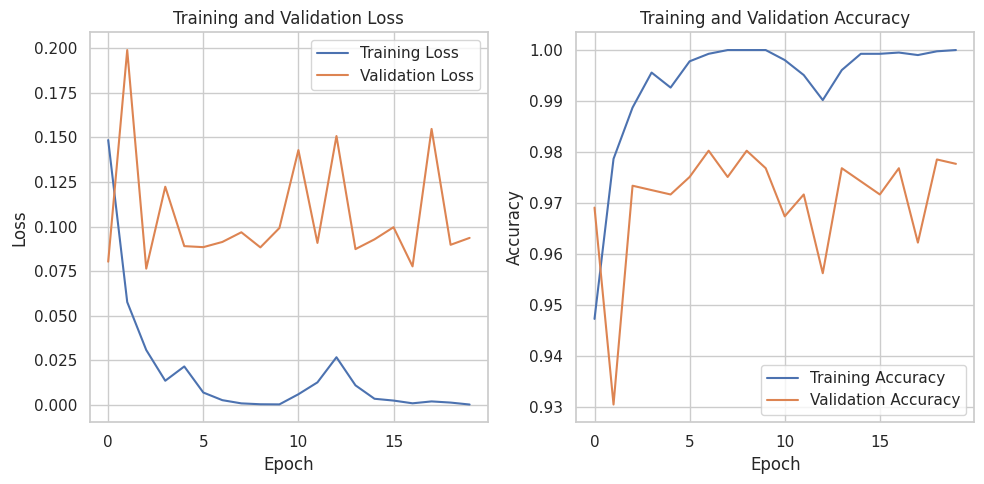

In [57]:
import matplotlib.pyplot as plt

# Plot the training and validation loss over epochs
plt.figure(figsize=(10, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


# **Predictions on the Test Data**

Test Loss: 0.1288, Test Accuracy: 0.9759


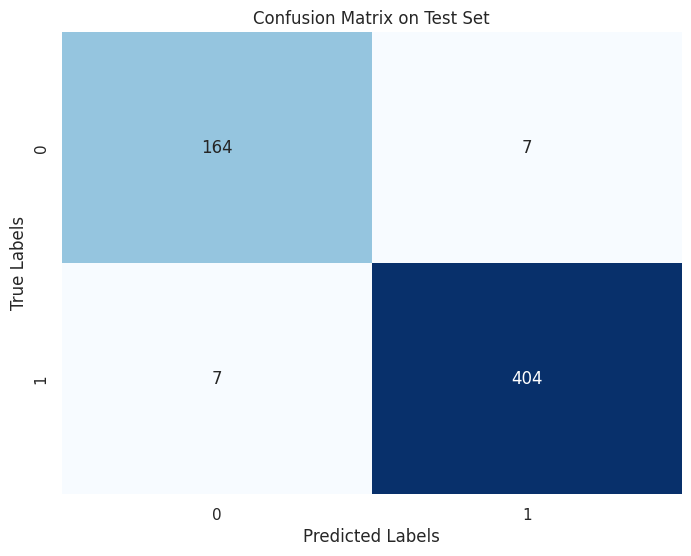

In [53]:
# Evaluation on test set
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        
        # Store the true and predicted labels
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix on Test Set')
plt.show()


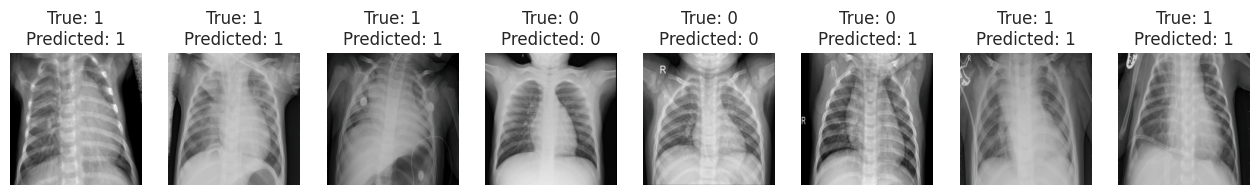

In [56]:
# Inverse normalization to convert back to the original image
inv_normalize = transforms.Normalize(
    mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
    std=[1/0.229, 1/0.224, 1/0.225]
)

# Define a function to visualize the results
def visualize_results(data_loader, true_labels, predicted_labels, num_samples):
    images = []
    for image_batch, _ in data_loader:
        images.extend(image_batch)
    
    random_indices = random.sample(range(len(images)), num_samples)

    fig, axes = plt.subplots(1, num_samples, figsize=(16, 2))
    for i, idx in enumerate(random_indices):
        ax = axes[i]
        img = images[idx]
        img = inv_normalize(img)  # Denormalize
        img = img.permute(1, 2, 0).cpu().numpy()  # Convert to HWC format for visualization
        img = (img * 255).astype(np.uint8)  # Convert back to uint8 for proper display

        true_label = true_labels[idx]
        predicted_label = predicted_labels[idx]
        ax.imshow(img)
        ax.set_title(f"True: {true_label}\nPredicted: {predicted_label}")
        ax.axis('off')
    plt.show()

# Visualize a random subset of test data along with their true and predicted labels
num_samples_to_visualize = 8
visualize_results(test_loader, y_true, y_pred, num_samples_to_visualize)
